**Homework 12**

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Add the code to the SGDRegressor class below to allow for variable amount of L1 and L2 regularization.

In [161]:
class SGDRegressor():
    def __init__(self,learning_rate, max_iter, batch_size, penalty=None, alpha=0.0001):
        self.lr=learning_rate
        self.max_iter=max_iter #number of epochs
        self.batch_size=batch_size
        self.penalty=penalty #either 'l1' or 'l2'
        self.alpha=alpha #amount of regularization to apply
        
    def fit(self,X,y):
        self.coef=np.ones((X.shape[1],)) #Initial values
        self.intercept=1 #Initial value
        if self.penalty=='l1':
            penalty_grad=lambda x:x/abs(x)    #Type L1 gradient function here
        elif self.penalty=='l2':
            penalty_grad=lambda x:x      #Type L2 gradient function here
        else: penalty_grad= lambda x:0
        indices=np.arange(len(X))
        for i in range(self.max_iter):
            np.random.seed(i) #Just so everyone gets the same answer!
            np.random.shuffle(indices)
            X_shuffle=X[indices] 
            y_shuffle=y[indices] 
            for j in range(0,len(X),self.batch_size):
                X_batch=X_shuffle[j:j+self.batch_size]
                y_batch=y_shuffle[j:j+self.batch_size]
                residuals=self.predict(X_batch)-y_batch
                coef_grad=(X_batch.T)@residuals/len(X_batch)
                intercept_grad=np.mean(residuals)
                self.coef-=self.lr*coef_grad+self.alpha*penalty_grad(self.coef)
                self.intercept-=self.lr*intercept_grad+self.alpha*penalty_grad(self.intercept) #Penalty term
            
    def predict(self,X):
        # print("X", end= " ")
        # print(X.shape)
        # print("coef:", end= " ")
        # print(self.coef.shape)
        # print("inter: ", end="")
        # print(self.intercept)
        # print(X @ self.coef)
        return X@self.coef+self.intercept
    
    def mse(self,X,y): #Not a sklearn method, but added here for convenience
        return ((self.predict(X)-y)**2).mean()

We now bring back some familiar classes:

In [162]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

We now use L2 regularization to address overfitting of a polynomial model. To begin, we generate and visualize some data:

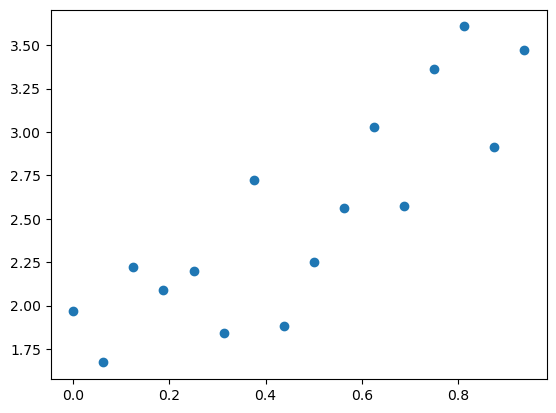

In [163]:
#Generate Data
np.random.seed(4)
x=np.arange(0,1,1/16)
randoms=np.random.rand(16)
y=2*x+1+randoms
plt.scatter(x,y)

Pre-process the data as follows:
1. Do a 75/25 train/test split
2. Create matrices from xtrain and xtest by adding columns corresponding to powers one through twelve of the original column. 

In [164]:
#Process Data:
xtrain,xtest,ytrain,ytest=train_test_split(x, y, test_size=0.25)
#Your Code Here
print(xtrain.shape)
d12=PolynomialFeatures(12,include_bias=False)
deg12xtrain=d12.fit_transform(xtrain[:,np.newaxis]) 
deg12xtest=d12.fit_transform(xtest[:,np.newaxis])
deg12xtrain.shape

(12,)


(12, 12)

Create an SGD model with no regularization. Use a learning rate of 0.1, max_iter of 10000, and batch_size of 16. Then, fit it to `deg12xtrain` and `ytrain`.

In [165]:
noreg= SGDRegressor(learning_rate=0.1, max_iter=10000, batch_size=16)
noreg.fit(deg12xtrain, ytrain)

Evaluate the MSE of your model on the train set:

In [166]:
noreg_mse_train= noreg.mse(deg12xtrain, ytrain)
print(ytrain.shape)
noreg_mse_train

(12,)


0.08002428305558902

Evaluate the MSE of your model on the test set:

In [167]:
noreg_mse_test= noreg.mse(deg12xtest, ytest)
noreg_mse_test


0.14346201670216494

Create a similar model, but with 0.01 of L2 regularization.

In [184]:
regmodel= SGDRegressor(learning_rate=0.1, max_iter=10000, batch_size=16, penalty='l2', alpha=0.01)
regmodel.fit(deg12xtrain, ytrain)

Evaluate the MSE of your new model on the train set. It will be higher than before, indicating a model that is not as good on the data it was trained on.

In [185]:
reg_mse_train= regmodel.mse(deg12xtrain, ytrain)
reg_mse_train

0.13233672767100194

Evaluate the MSE of your new model on the test set. It should be lower than before, indicating a better (less overfit) model.

In [186]:
reg_mse_test= regmodel.mse(deg12xtest, ytest)
reg_mse_test

0.08511478974291509



---

You will now explore the use of L1 regularization to do feature selection on the classic California housing dataset. Import it here:


In [171]:
from sklearn.datasets import fetch_california_housing
ca=fetch_california_housing(as_frame=True).frame
ca.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521


Check the shape to see how many observations and features you'll be dealing with:

In [172]:
ca.shape

(20640, 9)

Our goal is to find a model which predicts the MedHouseVal variable as accurately as possible, using as few of the other features as possible. 

To start, we'll create a feature matrix X containing all of the columns besides MedHouseVal, and a target vector y containing the entries in MedHouseVal.

In [173]:
X=np.array(ca.loc[:,'MedInc':'Longitude'])
y=np.array(ca['MedHouseVal'])

Now, do the following:
1. 80/20 Train-Test split.
2. Scale the training and testing feature matrices appropriately.
3. Fit a linear model using SGD on the train data with 1000 epochs, batch sizes of 5000, a learning rate of 0.01, and 0.001 of L1 regularization.
4. List the coefficients of your model.
5. Calculate the MSE on the test data.

In [174]:
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=.20)

In [175]:
#Your Code Here
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [176]:
ca_mod=SGDRegressor(learning_rate=0.01, max_iter=1000, batch_size=5000, penalty='l1', alpha=.001)
ca_mod.fit(X_train_scaled, y_train)

In [177]:
ca_mod_coefficients= ca_mod.coef
ca_mod_coefficients

array([ 7.06785329e-01,  1.10120785e-01, -4.37867112e-04, -2.66352031e-05,
       -5.74329533e-04,  7.80326965e-04, -1.20208854e-02, -1.06213586e-03])

In [178]:
ytest.shape

(4,)

In [179]:
preds = ca_mod.predict(X_test_scaled)
preds.shape

(4128,)

In [180]:
ytest.shape

(4,)

In [181]:
ca_mod_mse= ca_mod.mse(X_test_scaled, y_test)
ca_mod_mse

0.6843395918555473

Now, do the following:
1. Identify the two smallest coefficients of the model you created above. 
2. Create new feature matrices X_train_small and X_test_small from X_train_scaled and X_test_scaled using only those columns corresponding to the two coefficients that have the largest absolute value.
3. Create a new SGD model, with the same parameters as the previous one, but fit to X_train_small and y_train.
4. Check the MSE of your new model and compare it to the MSE of the previous one.

In [182]:

# new feaeture matrix with only the largest abs coeffients

least_two_idx = np.argsort(np.abs(ca_mod_coefficients))[-2:]
X_test_small= X_test_scaled[:, least_two_idx]
X_train_small= X_train_scaled[:, least_two_idx]

In [183]:
ca_mod_small= SGDRegressor(learning_rate=0.01, max_iter=1000, batch_size=5000, penalty='l1', alpha=.001)
ca_mod_small.fit(X_train_small, y_train)
ca_mod_small_mse= ca_mod_small.mse(X_test_small, y_test)
ca_mod_small_mse

0.6867746099456248